# Dog Classification Model Generation

Based on the following [tutorial](https://www.angioi.com/dog-breed-classification/)

TODO: merge with Google Collab [version](https://colab.research.google.com/drive/1E2S2lJyQ_87XdiOhjj4uRozDWZ-sQP3p?usp=sharing)

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [33]:
# download Standford Dogs dataset
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

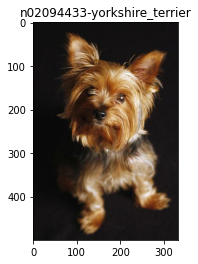

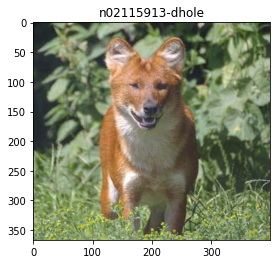

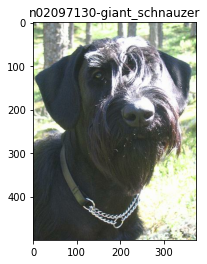

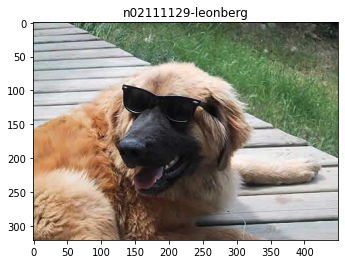

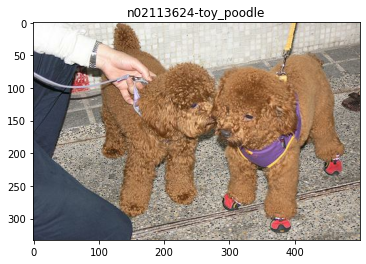

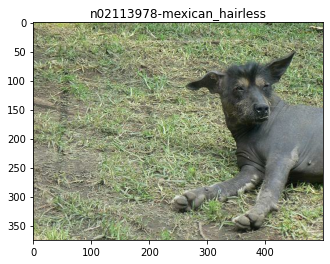

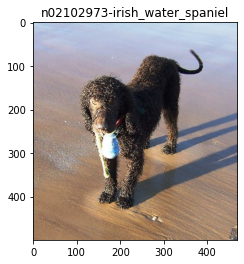

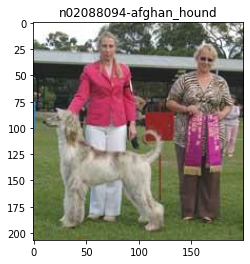

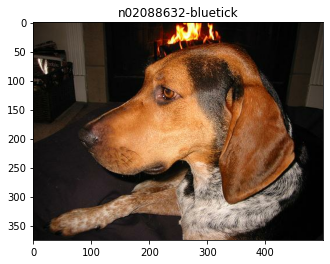

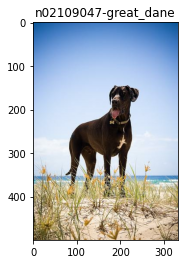

In [23]:
# convert label indices into breed names
get_name = info.features['label'].int2str

# preview a sample from dataset
for doggo in dataset['train'].take(10):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

In [28]:
# resize images to be the same size
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN, IMG_LEN, 3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):

    # Image conversion int -> float and resizing
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')

    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'], N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
        ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [25]:
# define base model - using ModelNetV2 for performance on mobile devices
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [26]:
# Add GlobalAveragePooling2D to transform tensor into vector
# Add Dense layer with number of neurons required for prediction
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

In [30]:
#  Compile and fit model
model.compile(
    optimizer=tf.keras.optimizers.Adamax(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

train_batches = prepare(training_data, batch_size=32)
test_batches = prepare(test_data, batch_size=32)

history = model.fit(train_batches, epochs=30, validation_data=test_batches)

Epoch 1/30
375/375 [==============================] - 298s 790ms/step - loss: 3.6270 - accuracy: 0.2238 - top_k_categorical_accuracy: 0.5358 - val_loss: 3.4089 - val_accuracy: 0.2774 - val_top_k_categorical_accuracy: 0.6295
Epoch 2/30
375/375 [==============================] - 287s 763ms/step - loss: 3.2152 - accuracy: 0.3326 - top_k_categorical_accuracy: 0.7027 - val_loss: 3.0837 - val_accuracy: 0.3672 - val_top_k_categorical_accuracy: 0.7455
Epoch 3/30
375/375 [==============================] - 289s 769ms/step - loss: 2.9012 - accuracy: 0.4190 - top_k_categorical_accuracy: 0.7980 - val_loss: 2.8028 - val_accuracy: 0.4383 - val_top_k_categorical_accuracy: 0.8138
Epoch 4/30
375/375 [==============================] - 303s 805ms/step - loss: 2.6289 - accuracy: 0.4833 - top_k_categorical_accuracy: 0.8549 - val_loss: 2.5603 - val_accuracy: 0.4936 - val_top_k_categorical_accuracy: 0.8554
Epoch 5/30
375/375 [==============================] - 313s 832ms/step - loss: 2.3935 - accuracy: 0.5367 

In [63]:
import json

label = info.features['label'].save_metadata('./')
# data = info.features['label'].to_json_content()


data = []

# preview a sample from dataset
for i in range(N_BREEDS):
    data.append(get_name(i))

# Serializing json
json_object = json.dumps(data, indent=4)

# # Writing to sample.json
with open("dog_labels.json", "w") as outfile:
    outfile.write(json_object)
